In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Test

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broke

In [2]:
using Plots
using LaTeXStrings

In [9]:
typeof(blobs) <: Vector{T} where {T<:PotentialFlow.Blobs.Blob}

true

In [11]:
?PotentialFlow.strength

No documentation found.

Binding `PotentialFlow.strength` does not exist.


In [12]:
function routine_plot(state::Vector{Float64}, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = cylinder_state_to_lagrange(state, config)
    Z = X .+ im*Y'
    ψ = imag.(LowRankVortex.F(Z, source))
    
    plt = plot(collect(X), collect(Y), ψ', ratio = 1.0, colorbar = false, 
                      xlim = (X[1], X[end]), 
                      ylim = (Y[1], Y[end]); levels = 10)
    
        
    θc = range(0,2π,length=201)
    zc = exp.(im*θc[1:end-1])
    plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
    
    if withvortices == true
        plot!(plt, source, markersize = 4, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

routine_plot(blobs, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true) = 
routine_plot(cylinder_lagrange_to_state(blobs, config), config, X, Y; withvortices=withvortices)


routine_plot (generic function with 2 methods)

### Configuration setup

In [46]:
# grid for evaluation
xgrid = range(-4,4,length=201)
ygrid = copy(xgrid)
zgrid = xgrid .+ im*ygrid';

# sensors on the unit circle
θsensors = range(0,2π,length=31)[1:end-1]
sensors = exp.(im*θsensors)

t0 = 0.0
tf = 1.0

# create configuration file
config_data = let Nv = 6, U = complex(0.0), 
             ss = sensors, Δt = 5e-3, δ = 1e-3,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

VortexConfig(6, 0.0 + 0.0im, ComplexF64[1.0 + 0.0im, 0.9781476007338057 + 0.20791169081775931im, 0.9135454576426009 + 0.40673664307580015im, 0.8090169943749475 + 0.5877852522924731im, 0.6691306063588582 + 0.7431448254773941im, 0.5000000000000001 + 0.8660254037844386im, 0.30901699437494745 + 0.9510565162951535im, 0.10452846326765368 + 0.9945218953682733im, -0.10452846326765333 + 0.9945218953682734im, -0.30901699437494734 + 0.9510565162951536im  …  -0.5000000000000004 - 0.8660254037844385im, -0.30901699437494756 - 0.9510565162951535im, -0.10452846326765423 - 0.9945218953682733im, 0.10452846326765299 - 0.9945218953682734im, 0.30901699437494723 - 0.9510565162951536im, 0.49999999999999933 - 0.866025403784439im, 0.6691306063588578 - 0.7431448254773946im, 0.8090169943749473 - 0.5877852522924734im, 0.9135454576426005 - 0.40673664307580093im, 0.9781476007338056 - 0.20791169081775987im], 0.005, 0.001, 0.0001, 0.0001, 1.0, 0.01)

### Generate the truth used in the twin experiment

In [50]:
σθ = 0.05*(2*π/(config_data.Nv))
θv = range(0,2π,length=config_data.Nv+1)[1:end-1] .+ σθ*randn(config_data.Nv)

r0 = 3.0
σr = 0.02*r0
rv = r0 .+ σr*randn(config_data.Nv)

Γ0 = 10.0
σΓ = 0.02*Γ0
zv = rv .* exp.(im*θv)
Γv = Γ0 .+ σΓ*randn(config_data.Nv)

blobs = Vortex.Blob.(zv,Γv,config_data.δ*ones(config_data.Nv))

data = generate_data_cylinder_twin_experiment(deepcopy(blobs), t0, tf, config_data,
       "/media/mat/HDD/LowRankVortex.jl/localization/")

tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/localization/data_cylinder_twin_experiment.jld", 
                      "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045  …  0.9550000000000001, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0], 0.005, [3.035408062521967, -0.26234588877544024, 9.999979605366772, 1.3463083352201148, 2.726571881219309, 10.079566325117966, -1.6529621924377211, 2.6119405752377207, 9.847540471979583, -2.9951267907745933, 0.05259626740467681, 9.656779551299577, -1.5903275833348975, -2.5005986220527974, 10.073351645140216, 1.5789577104781787, -2.4306742551350053, 10.155209310792824], [3.0351846922010246 3.035196514433736 … 2.679412500247463 2.676151841076087; -0.2622323380551541 -0.25526381143537447 … 0.9915975768069436 0.9973244404885802; … ; -2.4305580681718095 -2.4279760665320707 … -1.602334601998545 -1.597113574179133; 10.155382216067567 10.155317670534066 … 10.156270932525777 10.15625688781418], [-4.163285030192035 -4.159072132860806 … -4.404026035622634 -4.399458383103661; -4.071919004936795 -4.07994525334079 … -4.368565655110087 -4.3578

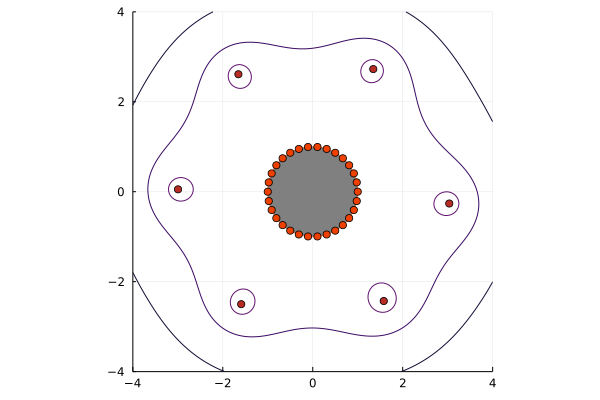

In [51]:
routine_plot(blobs, config_data, xgrid, ygrid)

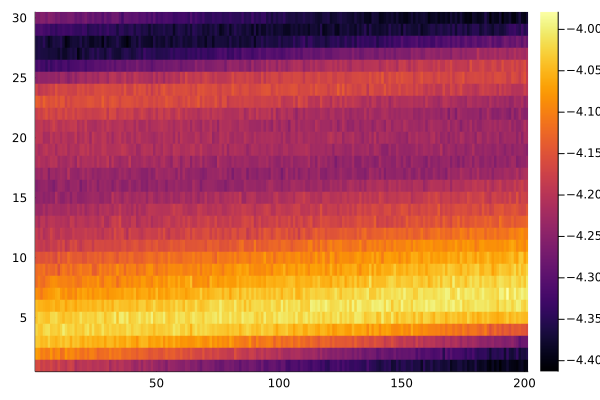

In [52]:
heatmap(data.yt)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
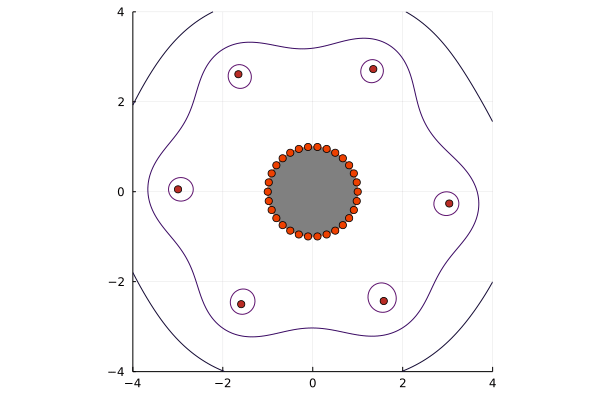

In [53]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid)
    next!(prog)
end

### Setup of the ensemble filter

In [54]:
config = deepcopy(config_data)

VortexConfig(6, 0.0 + 0.0im, ComplexF64[1.0 + 0.0im, 0.9781476007338057 + 0.20791169081775931im, 0.9135454576426009 + 0.40673664307580015im, 0.8090169943749475 + 0.5877852522924731im, 0.6691306063588582 + 0.7431448254773941im, 0.5000000000000001 + 0.8660254037844386im, 0.30901699437494745 + 0.9510565162951535im, 0.10452846326765368 + 0.9945218953682733im, -0.10452846326765333 + 0.9945218953682734im, -0.30901699437494734 + 0.9510565162951536im  …  -0.5000000000000004 - 0.8660254037844385im, -0.30901699437494756 - 0.9510565162951535im, -0.10452846326765423 - 0.9945218953682733im, 0.10452846326765299 - 0.9945218953682734im, 0.30901699437494723 - 0.9510565162951536im, 0.49999999999999933 - 0.866025403784439im, 0.6691306063588578 - 0.7431448254773946im, 0.8090169943749473 - 0.5877852522924734im, 0.9135454576426005 - 0.40673664307580093im, 0.9781476007338056 - 0.20791169081775987im], 0.005, 0.001, 0.0001, 0.0001, 1.0, 0.01)

In [55]:
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

senkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)
lrenkf = LREnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

LREnKF  with filtered = true


In [56]:
# Generate the initial condition

Ne = 30
Ny = length(config_data.ss)
Nx = 3*config_data.Nv

X0 = zeros(Ny+Nx, Ne)


for i=1:Ne
    θi = range(0,2π,length=config_data.Nv+1)[1:end-1] .+ σθ*randn(config_data.Nv)
    ri = r0 .+ σr*randn(config_data.Nv)
    zi = ri .* exp.(im*θi)
    Γi = Γ0 .+ σΓ*randn(config_data.Nv)
    
    bi = Vortex.Blob.(zi,Γi,config_data.δ*ones(config_data.Nv))
    X0[Ny+1:Ny+Nx,i] .= cylinder_lagrange_to_state(bi, config_data)
end

X = deepcopy(X0);

In [8]:
### Time marching of the vortices

In [9]:


n0 = ceil(Int64, t0/config_data.Δt) + 1
J = (tf-t0)/config_data.Δt
Acycle = n0:n0+J-1


cachevels = allocate_velocity(blobs)
Xf = Array{Float64,2}[]
push!(Xf, copy(state(X0, Ny, Nx)))

t = 0.0
for i=1:length(Acycle)
    t += config_data.Δt
    X, _ = cylinder_vortex(X, 0.0, Ny, Nx, cachevels, config_data)
    push!(Xf, deepcopy(state(X, Ny, Nx)))
end

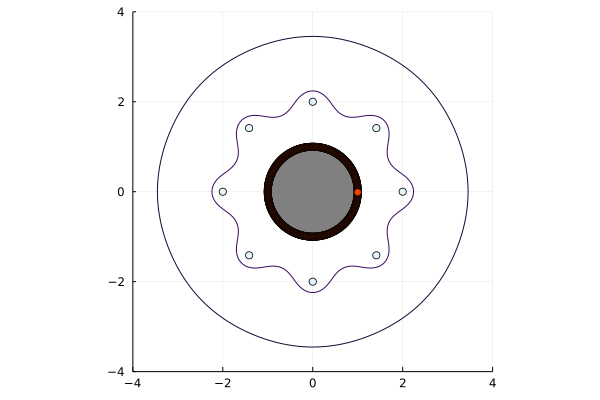

In [10]:
routine_plot(mean(Xf[1]; dims = 2)[:,1], config_data, xgrid, ygrid)

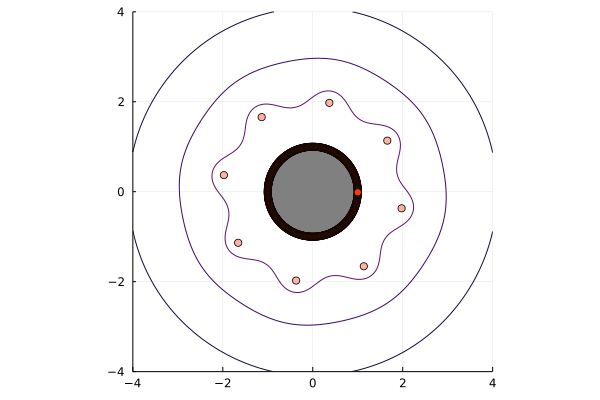

In [11]:
routine_plot(mean(Xf[end]; dims = 2)[:,1], config_data, xgrid, ygrid)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
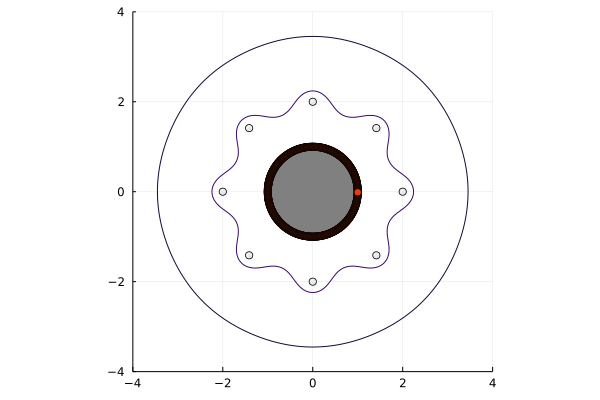

In [12]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(mean(Xf[nsnap]; dims = 2)[:,1], config_data, xgrid, ygrid)
    next!(prog)
end

In [13]:
J = zeros(length(config_data.ss), Nx)

@time for i=1:config_data.Nv
    dpdzi = dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))
    J[:,3*i-2] .= 2*real(dpdzi)  
    J[:,3*i-1] .= -2*imag(dpdzi)
    
    dpdΓi = dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))
    J[:,3*i] .= dpdΓi
end

  0.667607 seconds (1.15 M allocations: 65.267 MiB, 27.82% gc time, 94.36% compilation time)


In [14]:
U, Λ, V = svd(J);

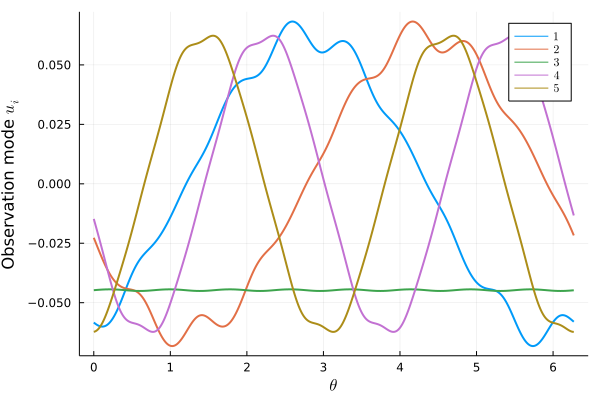

In [28]:
plt = plot(xlabel = L"\theta", ylabel = "Observation mode "*L"u_i")

for i=1:5
    plot!(plt, θsensors, U[:,i], linewidth = 2, label = latexstring(i))
end
#scatter!(plt, θsensors, zero(θsensors), markersize = 5)

plt

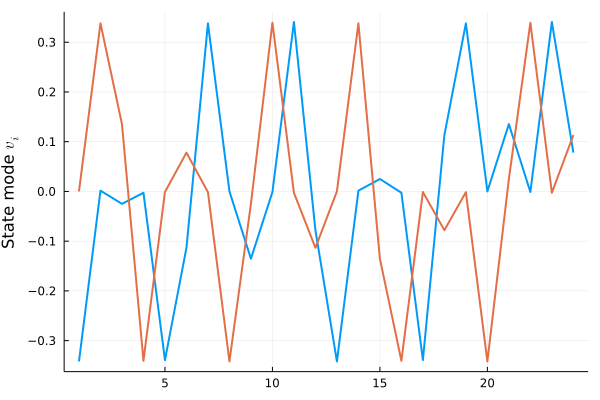

In [31]:
plt = plot(ylabel = "State mode "*L"v_i", legend = false)

for i=1:2
    plot!(plt, V[:,i], linewidth = 2)
end
plt

In [32]:
Cy = J*J'
Λy = sqrt.(svd(Cy).S)
cumsum((Λy.^2)./sum(Λy.^2))

500-element Vector{Float64}:
 0.22816348824488816
 0.45632697648977577
 0.6704912288390016
 0.7687093070930963
 0.8669273853471903
 0.9171421839348132
 0.9673569825224361
 0.9817055280593932
 0.9942820795381175
 0.9959989758885006
 0.9977158722388837
 0.9985156885775845
 0.9993155049162853
 ⋮
 0.9999999999999987
 0.9999999999999987
 0.9999999999999987
 0.9999999999999988
 0.9999999999999988
 0.9999999999999988
 0.9999999999999988
 0.9999999999999988
 0.9999999999999988
 0.9999999999999989
 0.9999999999999989
 0.9999999999999989

In [33]:
Cx = J'*J
Λx = sqrt.(svd(Cx).S)
cumsum((Λx.^2)./sum(Λx.^2))

24-element Vector{Float64}:
 0.2281634882448905
 0.4563269764897807
 0.6704912288390086
 0.7687093070931043
 0.8669273853471992
 0.9171421839348226
 0.9673569825224461
 0.9817055280594033
 0.9942820795381277
 0.9959989758885108
 0.9977158722388939
 0.9985156885775948
 0.9993155049162955
 0.9995853205303453
 0.999855136144395
 0.9998956660044431
 0.9999357895462438
 0.9999486468847354
 0.9999615042232269
 0.9999704197867598
 0.9999793353502927
 0.9999868068469013
 0.9999934034234506
 0.9999999999999998

In [34]:
(cumsum(Λ.^2)./sum(Λ.^2))

24-element Vector{Float64}:
 0.22816348824489047
 0.4563269764897805
 0.6704912288390087
 0.7687093070931044
 0.8669273853471993
 0.9171421839348227
 0.9673569825224462
 0.9817055280594033
 0.9942820795381277
 0.9959989758885108
 0.9977158722388939
 0.9985156885775948
 0.9993155049162955
 0.9995853205303452
 0.9998551361443949
 0.999895666004443
 0.9999357895462438
 0.9999486468847354
 0.9999615042232268
 0.9999704197867597
 0.9999793353502926
 0.9999868068469013
 0.9999934034234506
 0.9999999999999999

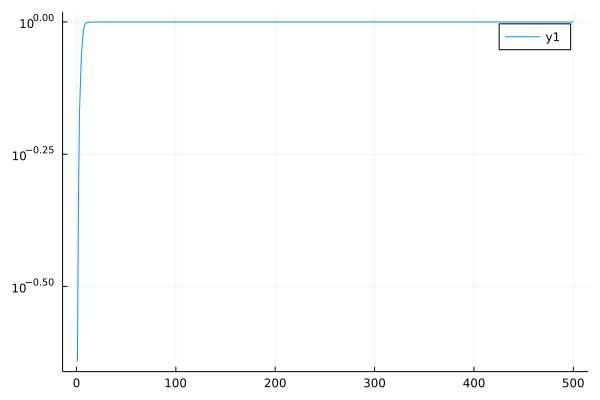

In [35]:
plot(cumsum(Λy.^2)./sum(Λy.^2), yscale = :log10)

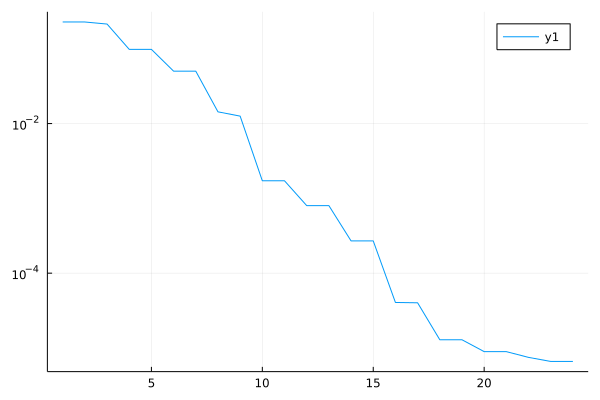

In [36]:
plot((Λ.^2)./sum(Λ.^2), yscale = :log10)

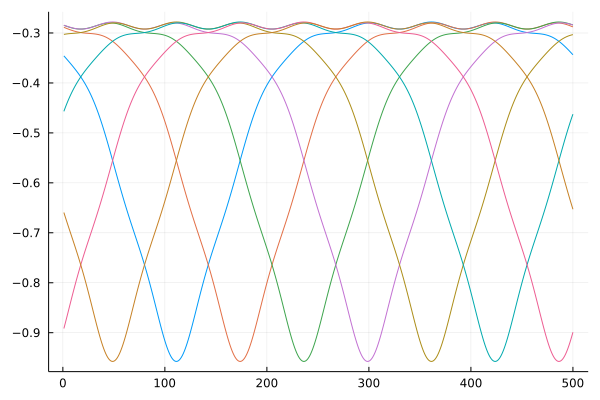

In [37]:
plt = plot(legend = false)

for i=1:config_data.Nv
    #plot!(plt, real(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    #plot!(plt, imag(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    plot!(plt, dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data)))
end
plt

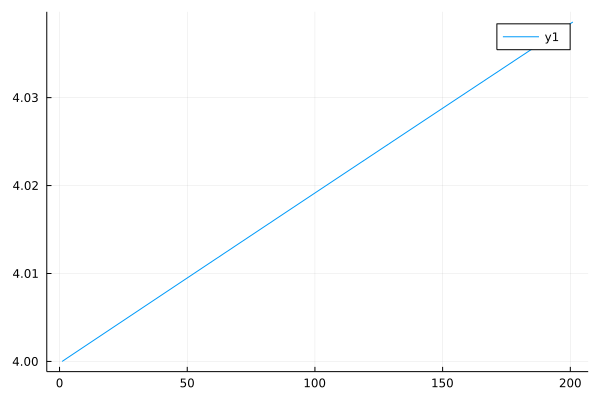

In [23]:
plot(map(xi -> xi[1]^2 + xi[2]^2, Xf))

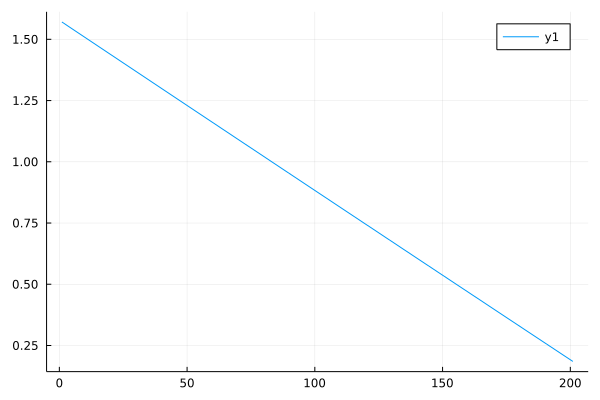

In [24]:
plot(map(xi -> atan(xi[1], xi[2]), Xf))

In [25]:
-ΓJ/(4*π^2*(abs2(zJ)*(abs2(zJ)-1)))

-0.626347670570229

In [26]:
10-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.5524030608054593 + 1.4966356498690878im, 1.777087057229044, 1.0e-7)
 Vortex.Blob(0.30297956811366955 - 1.5310233453394266im, 2.9950386389152985, 1.0e-7)
 Vortex.Blob(1.9533834668703678 + 1.5266552994597413im, 1.2339447083625958, 1.0e-7)
 Vortex.Blob(-1.0513133042403213 - 1.8227794557170132im, 1.6223707566499805, 1.0e-7)
 Vortex.Blob(-1.0836095985941654 + 0.7843079480127662im, 1.2450142628958365, 1.0e-7)
 Vortex.Blob(1.3467972420595151 + 0.7119955880276292im, 2.3945872015751033, 1.0e-7)
 Vortex.Blob(-1.543405087720262 - 0.948819867733115im, 2.391208846205823, 1.0e-7)
 Vortex.Blob(1.7504807284205954 - 1.4213977275321987im, 1.3496791100069796, 1.0e-7)
 Vortex.Blob(-1.2616569955408155 + 0.3668878315302502im, 1.7170363502434927, 1.0e-7)
 Vortex.Blob(0.9089535560506601 - 1.9950164010242206im, 1.6791417364879595, 1.0e-7)

LoadError: syntax: extra token "Vector" after end of expression